In [15]:
import os 
import torch
from dataset import Comma10kDataset, train_test_split, get_test_transforms
import matplotlib.pyplot as plt 

In [6]:
comma10k_dir = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k"
imgs_root = os.path.join(comma10k_dir, "imgs")
masks_root = os.path.join(comma10k_dir, "masks")
classes = [41, 76, 90, 124, 161]

In [7]:
train_imgs, test_imgs = train_test_split(imgs_root)

In [8]:
len(test_imgs)

989

In [12]:
test_dataset = Comma10kDataset(imgs_root, masks_root, test_imgs, classes, get_test_transforms())

In [21]:
for img, mask in test_dataset:
    print(img.size())
    print(mask.size())
    break

torch.Size([3, 448, 576])
torch.Size([5, 448, 576])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


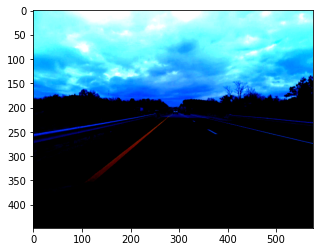

In [22]:
img = torch.transpose(img, 0, 2)
img = torch.transpose(img, 0, 1).numpy()
plt.imshow(img)

In [23]:
mask = mask.numpy()

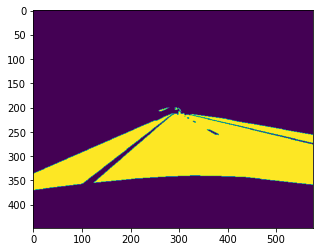

In [24]:
plt.imshow(mask[0])

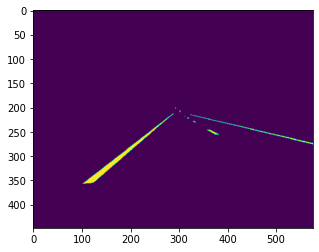

In [25]:
plt.imshow(mask[1])

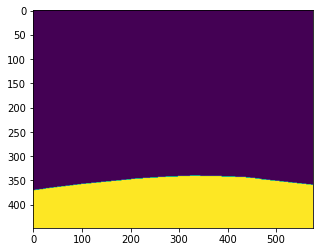

In [26]:
plt.imshow(mask[2])

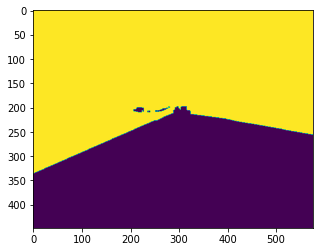

In [27]:
plt.imshow(mask[3])

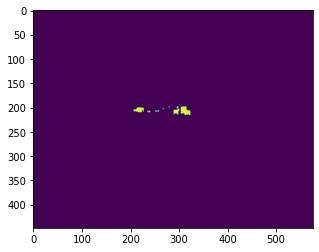

In [28]:
plt.imshow(mask[4])

# Test Model

In [66]:
import os 
import cv2
import random 
import glob 
import torch 
import torch.nn.functional as F
import numpy as np
from model import RegSeg
import matplotlib.pyplot as plt 

from PIL import ImageColor

import albumentations as A 
from albumentations.pytorch import ToTensorV2

In [67]:
imgs_folder = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs"
masks_folder = "/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/masks"
checkpoint = "/home/johann/sonstiges/comma10k-segmenation-pytorch/exps/2022-03-30/final.pth"
classes = [41, 76, 90, 124, 161]

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
model = RegSeg(num_classes=len(classes))
model.load_state_dict(torch.load(checkpoint))
model.to(device)

RegSeg(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (d_block_1_4): DBlock(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace=True)
      (conv4): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1))
      (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [70]:
transform = A.Compose([
    A.Resize(height=14*32, width=18*32), #height, width
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

In [71]:
test_imgs = glob.glob(imgs_folder + "/*.png")
samples = random.sample(test_imgs, 5)
for sample in samples:
    print(sample)

/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/2481_70843b83b4ddae85_2018-08-05--21-50-33_24_1067.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/2564_0085e9e41513078a_2018-08-10--00-30-53_9_748.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/4160_9058745e0dc8fa5f_2018-11-07--07-20-19_13_367.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/7384_7e34a988419b5307_2019-06-23--19-32-14_4_1096.png
/home/johann/sonstiges/comma10k-segmenation-pytorch/comma10k/imgs/1697_dad4fa0b6f4978ea_2018-08-04--00-13-09_10_227.png


In [72]:
def predict(model, img_path, transforms, device):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_img = transforms(image=img)["image"]
    transformed_img = transformed_img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(transformed_img)
    
    pred = torch.sigmoid(pred)
    pred = pred.detach().cpu().squeeze().numpy()
    
    return pred

In [73]:
pred_0 = predict(model, samples[0], transform, device)

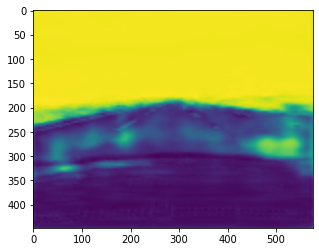

In [74]:
plt.imshow(pred_0[3])

In [75]:
channel2color = {
    0: "#402020",
    1: "#ff0000",
    2: "#cc00ff",
    3: "#808060",
    4: "#00ff66",
}

In [76]:
channel2class = {
    0: "road",
    1: "lane markings",
    2: "my car",
    3: "undrivable",
    4: "movable",
}

In [77]:
class_names = [
    "road",
    "lane markings",
    "undrivable",
    "movable",
    "my car"
]

In [78]:
hex_colors = [
    "#402020",
    "#ff0000",
    "#808060",
    "#00ff66",
    "#cc00ff",
]

In [79]:
rgb_colors = [list(ImageColor.getcolor(color, "RGB")) 
                   for color in list(channel2color.values())]
rgb_colors               

[[64, 32, 32], [255, 0, 0], [204, 0, 255], [128, 128, 96], [0, 255, 102]]

In [80]:
rgb_colors = np.array(rgb_colors).astype("uint8")

In [81]:
def plot_segmentation(
    model, 
    img_path, 
    classes,
    colors,
    transforms, 
    device, 
    figsize=(16,9),
    img_weight=0.5,
):
    pred = predict(model, img_path, transforms, device)
    classMap = np.argmax(pred, axis=0)
    
    colored_mask = colors[classMap]
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    colored_mask = cv2.resize(
        colored_mask, 
        (image.shape[1], image.shape[0]), 
        interpolation=cv2.INTER_NEAREST,
    )
    
    output = ((img_weight * image) + ((1. - img_weight) * colored_mask)).astype("uint8")
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(output)

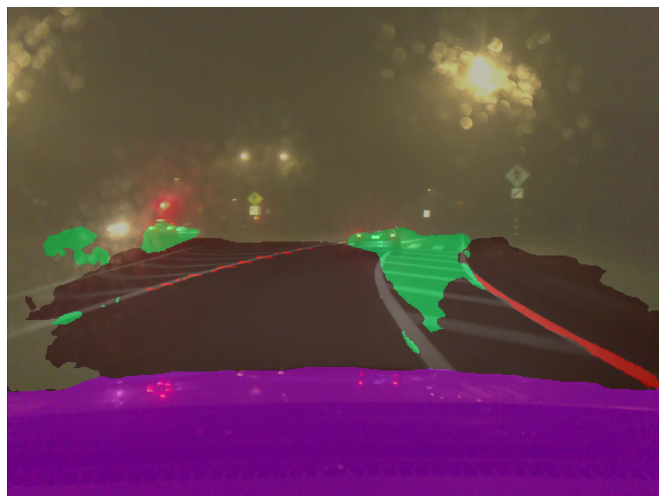

In [82]:
plot_segmentation(
    model, 
    samples[1], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

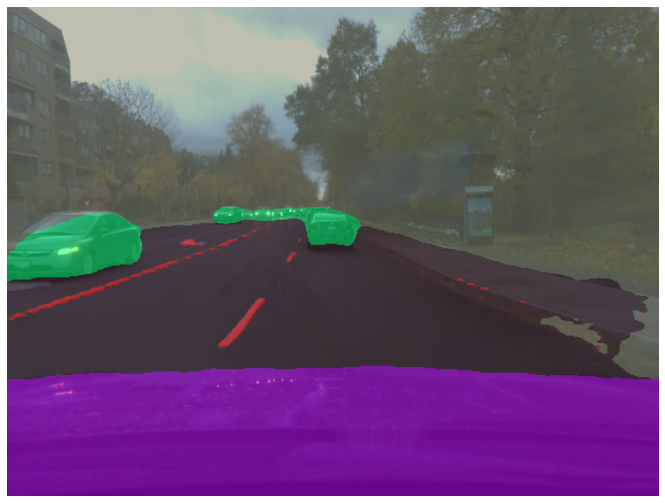

In [83]:
plot_segmentation(
    model, 
    samples[2], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

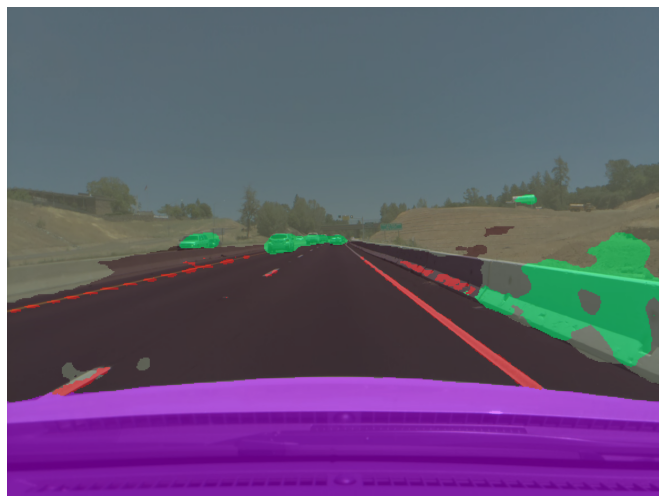

In [84]:
plot_segmentation(
    model, 
    samples[3], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

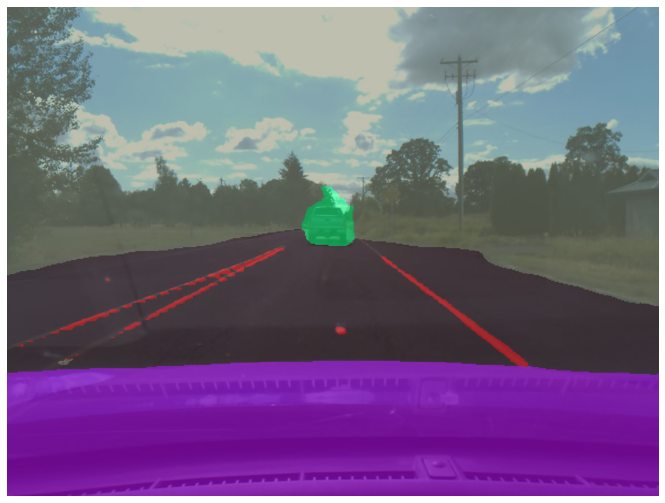

In [85]:
plot_segmentation(
    model, 
    samples[4], 
    classes, 
    rgb_colors, 
    transform, 
    device,
)

In [98]:
def plot_pred2tgt(
    model, 
    img_path, 
    classes,
    colors,
    transforms, 
    device,
    masks_folder,
    outname="/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example.jpg",
    figsize=(12,5),
    img_weight=0.5,
):
    _, filename = os.path.split(img_path)
    mask_path = os.path.join(masks_folder, filename)
    
    pred = predict(model, img_path, transforms, device)
    classMap = np.argmax(pred, axis=0)
    
    colored_mask = colors[classMap]
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    tgt_mask = cv2.imread(mask_path)
    tgt_mask = cv2.cvtColor(tgt_mask, cv2.COLOR_BGR2RGB)
    
    colored_mask = cv2.resize(
        colored_mask, 
        (image.shape[1], image.shape[0]), 
        interpolation=cv2.INTER_NEAREST,
    )
    
    output = ((img_weight * image) + ((1. - img_weight) * colored_mask)).astype("uint8")
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
   
    axs[0].imshow(output)
    axs[0].set_title('Prediction')
    axs[0].axis('off')
    axs[1].imshow(tgt_mask)
    axs[1].set_title('Groundtruth')
    axs[1].axis('off')
    fig.tight_layout()
    plt.show()
    fig.savefig(outname)

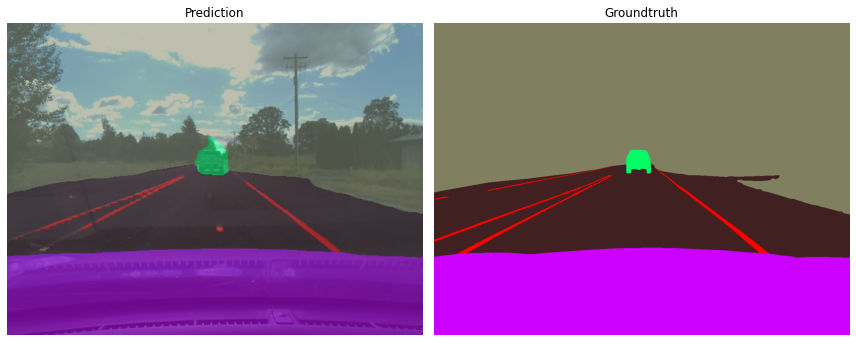

In [99]:
plot_pred2tgt(
    model, 
    samples[4], 
    classes, 
    rgb_colors, 
    transform, 
    device,
    masks_folder,
    "/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example-0.jpg",
)

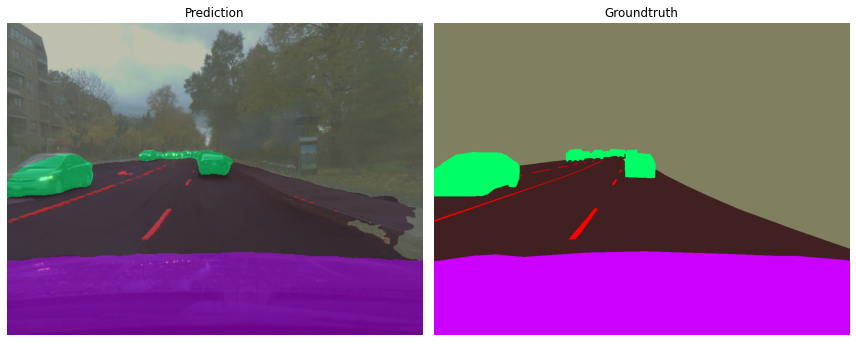

In [100]:
plot_pred2tgt(
    model, 
    samples[2], 
    classes, 
    rgb_colors, 
    transform, 
    device,
    masks_folder,
    "/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example-1.jpg"
)

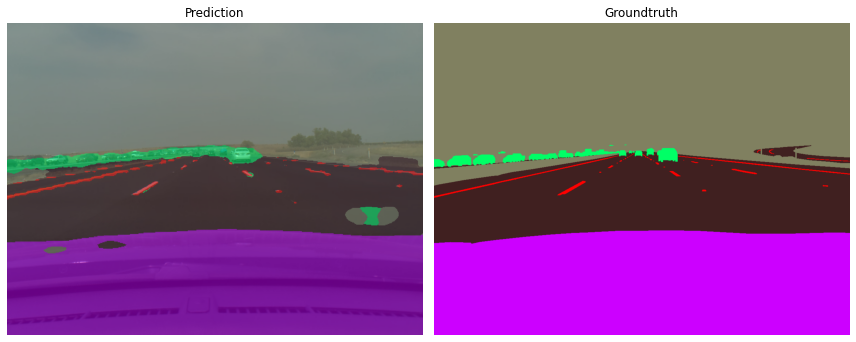

In [101]:
plot_pred2tgt(
    model, 
    samples[0], 
    classes, 
    rgb_colors, 
    transform, 
    device,
    masks_folder,
    "/home/johann/sonstiges/comma10k-segmenation-pytorch/assets/example-2.jpg"
)